In [1]:
import geopandas as gpd
import numpy as np

import pygmo as pg

from scipy import optimize

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import contextily as ctx
%matplotlib inline

In [2]:
n_sensors = 20

## Load Data

Processed in population_data.ipynb notebook.

In [42]:
tyne_oa = gpd.read_file("../data/processed/tyne_oa")
tyne_oa.head()

oa11cd    lad11cd           X           Y  Population  \
0  E00042042  E08000021  421259.393  564639.754         310   
1  E00042043  E08000021  420448.616  564819.213         304   
2  E00042044  E08000021  420509.207  564622.209         246   
3  E00042045  E08000021  421551.722  564088.460         201   
4  E00042046  E08000021  422116.597  563648.529         424   

                                            geometry  
0  POLYGON ((421301.772 564928.429, 421301.755 56...  
1  POLYGON ((420572.364 564892.821, 420572.312 56...  
2  POLYGON ((420492.559 564780.806, 420492.590 56...  
3  POLYGON ((421543.715 563955.116, 421542.251 56...  
4  POLYGON ((422650.214 563568.422, 422650.020 56...

In [4]:
print(tyne_oa.X.min(), tyne_oa.X.max())
print(tyne_oa.Y.min(), tyne_oa.Y.max())

413067.0710000005 429849.7170000002
563224.0130000003 577386.1339999996


In [5]:
populations = tyne_oa["Population"]

## Calculate Distances Between Output Areas

In [6]:
centroids = np.array([tyne_oa["X"], tyne_oa["Y"]]).T
centroids.shape

(952, 2)

In [7]:
dist_sq = np.sum((centroids[:, np.newaxis, :] - centroids[np.newaxis, :, :]) ** 2,
                 axis = -1)

distances = np.sqrt(dist_sq)

Max distance of 16923.71770783074 m is between E00042743 and E00139704


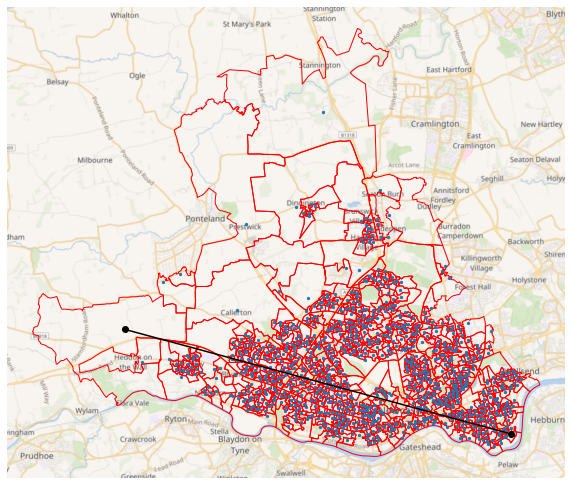

In [8]:
max_idx = np.where(distances == distances.max())[0]
print("Max distance of",
      distances.max(),
      "m is between",
      tyne_oa.iloc[max_idx[0]]["oa11cd"],
      "and", tyne_oa.iloc[max_idx[1]]["oa11cd"])

ax = tyne_oa.plot(figsize=(10,10), facecolor='none', edgecolor='red')
ctx.add_basemap(ax,
                url="https://maps.wikimedia.org/osm-intl/{z}/{x}/{y}.png",
                crs=tyne_oa.crs)

x = tyne_oa["X"]
y = tyne_oa["Y"]
ax.scatter(x, y, s=5)

x = tyne_oa.iloc[max_idx]["X"]
y = tyne_oa.iloc[max_idx]["Y"]
ax.plot(x, y, 'k-o')

ax.set_axis_off()

## Calculate "coverage"

coverage at any output area due to a sensor placed in any other output area.

In [9]:
def distance_to_coverage(distance, theta=1):
    return np.exp(- distance / theta)

distance_to_coverage = np.vectorize(distance_to_coverage)

Text(0, 0.5, 'coverage')

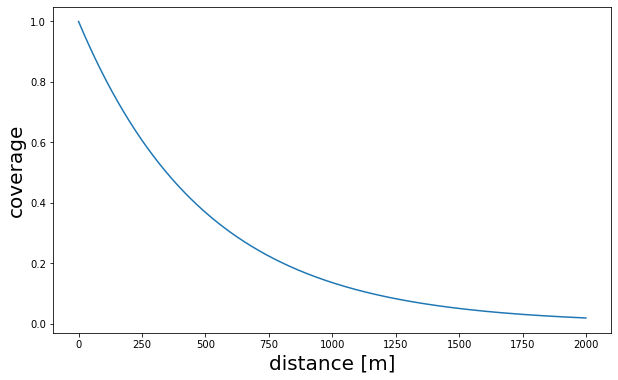

In [10]:
theta = 500

d = np.arange(0, 2000)
plt.figure(figsize=(10,6))
plt.plot(d, distance_to_coverage(d, theta=theta))
plt.xlabel("distance [m]", fontsize=20)
plt.ylabel("coverage", fontsize=20)

#plt.tight_layout()
#plt.savefig("../data/img/coverage_metric.png")

In [11]:
# "coverage" at each output area due to a sensor at any other output area
coverage = distance_to_coverage(distances, theta=theta)

Text(0.5, 1, 'coverage due to sensor at E00042042')

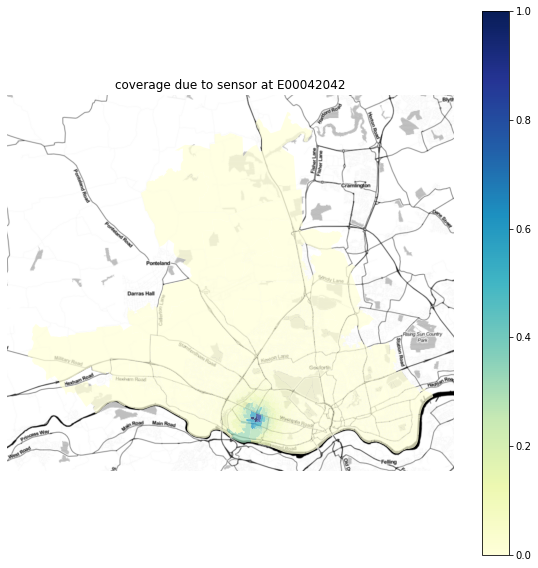

In [12]:
# coverage due to sensor at this output area index
sensor_idx = 0

tyne_oa["coverage"] = coverage[sensor_idx]

ax = tyne_oa.plot(column="coverage",
                  figsize=(10,10),alpha=0.75,
                  cmap="YlGnBu", legend=True)

ctx.add_basemap(ax,
                url="http://a.tile.stamen.com/toner/{z}/{x}/{y}.png",
                crs=tyne_oa.crs)

ax.set_axis_off()
plt.title("coverage due to sensor at " +
          tyne_oa.iloc[sensor_idx]["oa11cd"])

In [13]:
def plot_sensors(sensors,
                 figsize=(20,20),
                 print_sensors=True,
                 save_path=None):
    """
    Plot map with sensor locations (red points), output area centroids (black points),
    and coverage (shaded areas).
    """
    # only keep coverages due to output areas where a sensor is present
    mask_cov = np.multiply(coverage, sensors[np.newaxis, :])

    # coverage at each output area = coverage due to nearest sensor
    max_mask_cov = np.max(mask_cov, axis=1)

    # population weighted average coverage
    avg_coverage = (populations * max_mask_cov).sum() / populations.sum()
    
    tyne_oa["coverage"] = max_mask_cov

    # to make colorbar same size as graph:
    # https://www.science-emergence.com/Articles/How-to-match-the-colorbar-size-with-the-figure-size-in-matpltolib-/
    ax = plt.figure(figsize=figsize).gca()
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    ax = tyne_oa.plot(column="coverage",
                      alpha=0.75,
                      cmap="plasma", legend=True,
                      ax=ax, cax=cax)


    x = tyne_oa[sensors == 1]["X"]
    y = tyne_oa[sensors == 1]["Y"]
    ax.scatter(x, y, s=24, color='r')

    x = tyne_oa[sensors == 0]["X"]
    y = tyne_oa[sensors == 0]["Y"]
    ax.scatter(x, y, s=4, color='k')


    ctx.add_basemap(ax,
                    url="http://a.tile.stamen.com/toner/{z}/{x}/{y}.png",
                    crs=tyne_oa.crs)

    ax.set_axis_off()
    ax.set_title("n_sensors = {:.0f}, coverage = {:.2f}".format(sensors.sum(), avg_coverage),
                fontsize=20)
    
    # output areas with sensors
    if print_sensors:
        print("Output areas with sensors:",
              tyne_oa[sensors == 1]["oa11cd"].values)
        
    if save_path:
        plt.tight_layout()
        plt.savefig(save_path, dpi=300)

## Baseline 1: place sensors in output areas with largest population

Output areas with sensors: ['E00042147' 'E00042228' 'E00042580' 'E00042600' 'E00042609' 'E00042644'
 'E00042669' 'E00042672' 'E00042673' 'E00042679' 'E00042820' 'E00042877'
 'E00043549' 'E00175564' 'E00175572' 'E00175574' 'E00175578' 'E00175584'
 'E00175591' 'E00175593']


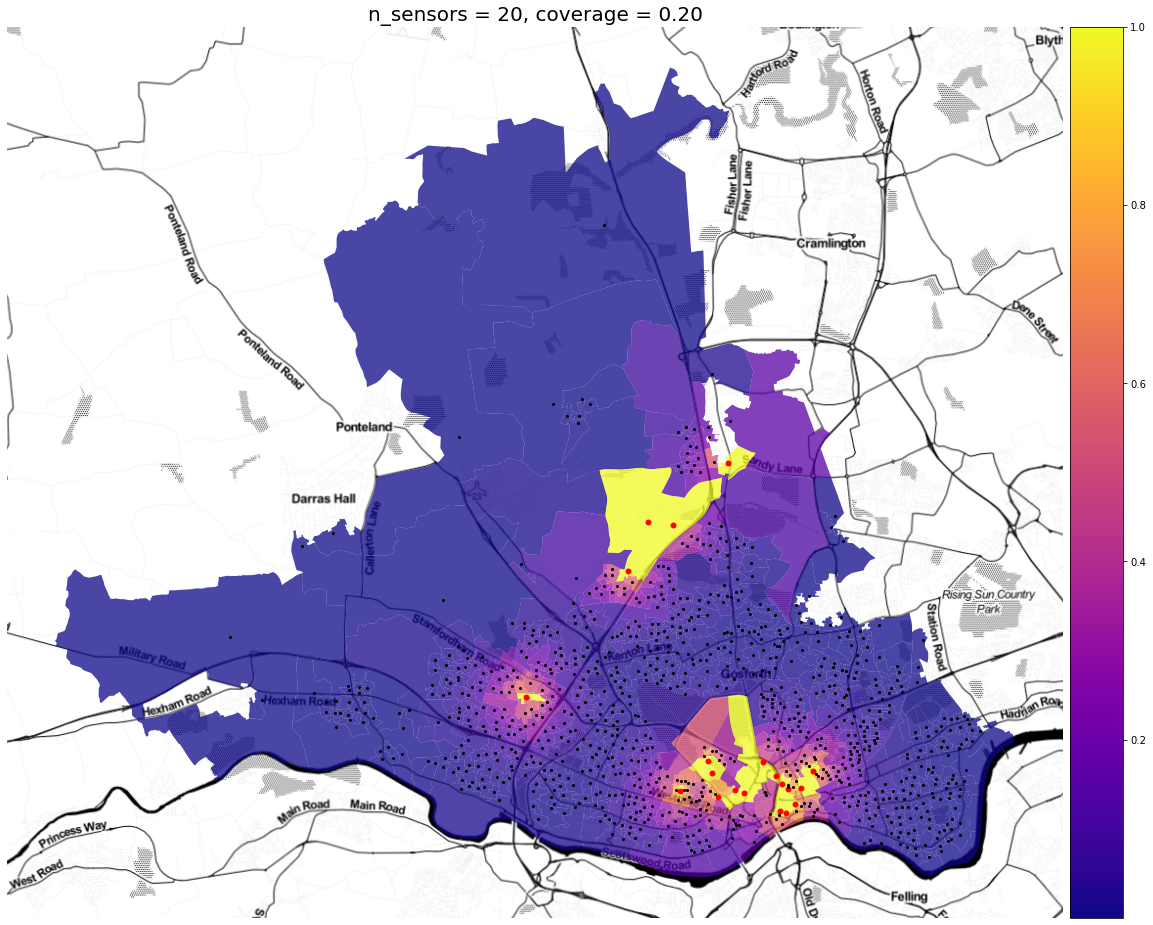

In [14]:
sensors = np.zeros((len(tyne_oa)))

top_idx = tyne_oa["Population"].sort_values(ascending=False).head(n_sensors).index

sensors[top_idx] = 1

plot_sensors(sensors)

## Baseline 2: Place sensors in random output areas

Output areas with sensors: ['E00042045' 'E00042054' 'E00042241' 'E00042253' 'E00042316' 'E00042339'
 'E00042366' 'E00042408' 'E00042479' 'E00042491' 'E00042510' 'E00042519'
 'E00042524' 'E00042601' 'E00042657' 'E00042736' 'E00042788' 'E00042872'
 'E00175573' 'E00175605']


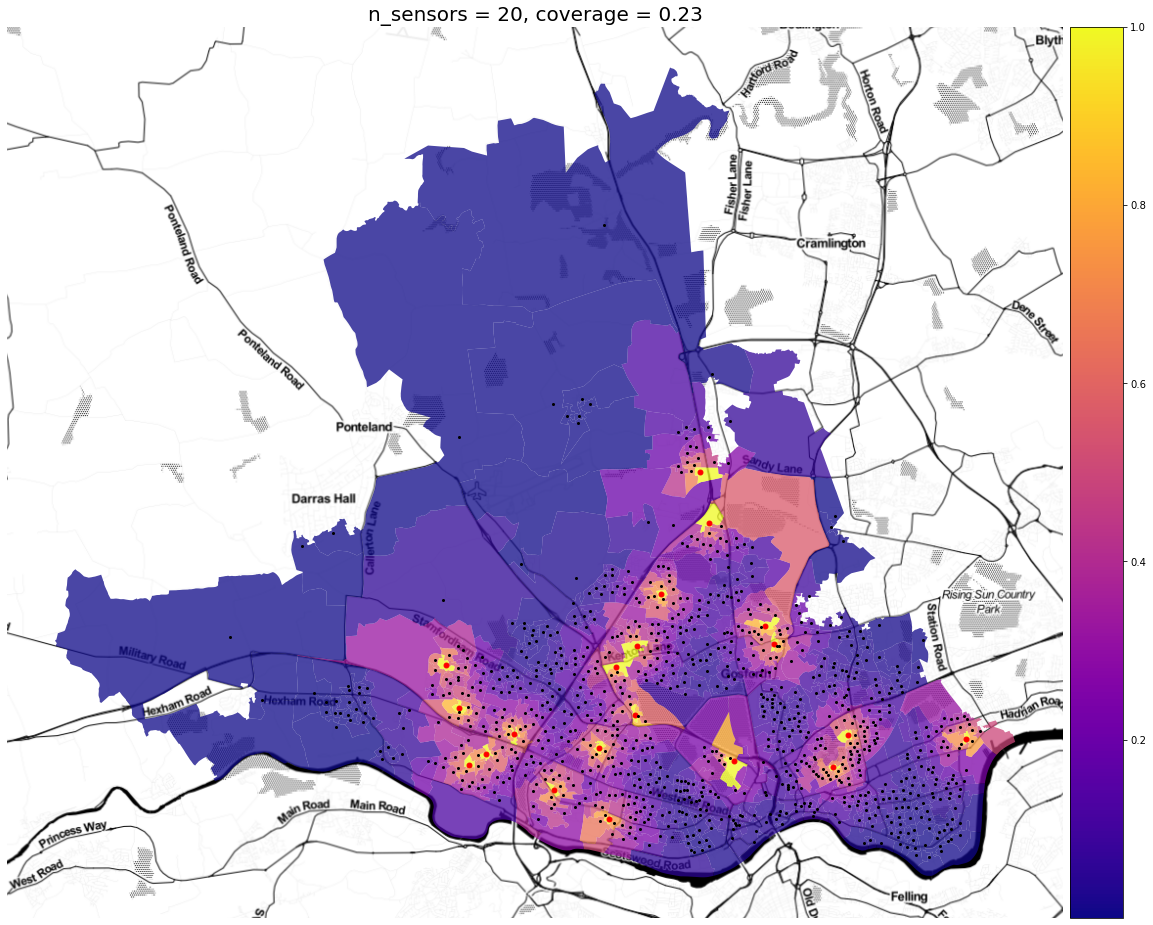

In [15]:
sensors = np.zeros((len(tyne_oa)))

# add sensors at random location
sensor_idx = np.random.randint(0, len(tyne_oa), size=n_sensors)
sensors[sensor_idx] = 1

plot_sensors(sensors)

## Greedy: Place sensors one by one in the place that maximises total coverage

Placing sensor 1 out of 20 ... coverage = 0.04
Placing sensor 2 out of 20 ... coverage = 0.08
Placing sensor 3 out of 20 ... coverage = 0.10
Placing sensor 4 out of 20 ... coverage = 0.12
Placing sensor 5 out of 20 ... coverage = 0.15
Placing sensor 6 out of 20 ... coverage = 0.17
Placing sensor 7 out of 20 ... coverage = 0.19
Placing sensor 8 out of 20 ... coverage = 0.21
Placing sensor 9 out of 20 ... coverage = 0.22
Placing sensor 10 out of 20 ... coverage = 0.23
Placing sensor 11 out of 20 ... coverage = 0.24
Placing sensor 12 out of 20 ... coverage = 0.26
Placing sensor 13 out of 20 ... coverage = 0.27
Placing sensor 14 out of 20 ... coverage = 0.28
Placing sensor 15 out of 20 ... coverage = 0.29
Placing sensor 16 out of 20 ... coverage = 0.30
Placing sensor 17 out of 20 ... coverage = 0.31
Placing sensor 18 out of 20 ... coverage = 0.32
Placing sensor 19 out of 20 ... coverage = 0.33
Placing sensor 20 out of 20 ... coverage = 0.34
DONE!
Average coverage: 0.34


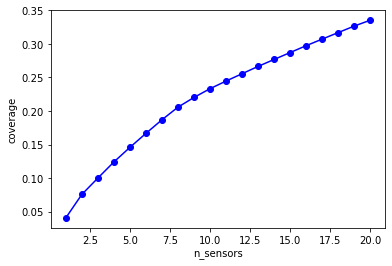

In [16]:
sensors = np.zeros((len(tyne_oa)))
save_plots = False
coverage_history = []
for s in range(n_sensors):
    # greedily add sensors
    print("Placing sensor", s+1, "out of", n_sensors, "... ", end='')
    
    best_coverage = 0
    best_sensors = sensors.copy()
    
    for oa in range(len(tyne_oa)):
        # try adding sensor at each output area
        
        if sensors[oa] == 1:
            # already have a sensor here, so skip to next
            continue
        
        else:
            new_sensors = sensors.copy()
            new_sensors[oa] = 1
            
            # only keep coverages due to output areas where a sensor is present
            mask_cov = np.multiply(coverage, new_sensors[np.newaxis, :])

            # coverage at each output area = coverage due to nearest sensor
            max_mask_cov = np.max(mask_cov, axis=1)
            
            # Avg coverage = population weighted sum across all output areas
            new_coverage = (populations * max_mask_cov).sum() / populations.sum()
            
            if new_coverage > best_coverage:
                # this output area is the best site for next sensor found so far
                best_sensors = new_sensors.copy()
                best_coverage = new_coverage
            
    sensors = best_sensors.copy()
    coverage_history.append(best_coverage)
    print("coverage = {:.2f}".format(best_coverage))
    if save_plots:
        plot_sensors(sensors,
                     save_path="../data/img/nsensors_{:03d}.png".format(s+1),
                     print_sensors=False)
        plt.close('all')

print("DONE!")
print("Average coverage: {:.2f}".format(best_coverage))
plt.plot(range(1,n_sensors+1), coverage_history, '-bo')
plt.xlabel("n_sensors")
plt.ylabel("coverage")
if save_plots:
    plt.savefig("../data/img/coverage.png", dpi=300)

Output areas with sensors: ['E00042043' 'E00042080' 'E00042214' 'E00042255' 'E00042267' 'E00042305'
 'E00042381' 'E00042429' 'E00042447' 'E00042521' 'E00042570' 'E00042621'
 'E00042661' 'E00042662' 'E00042791' 'E00042820' 'E00042846' 'E00042877'
 'E00042886' 'E00175591']


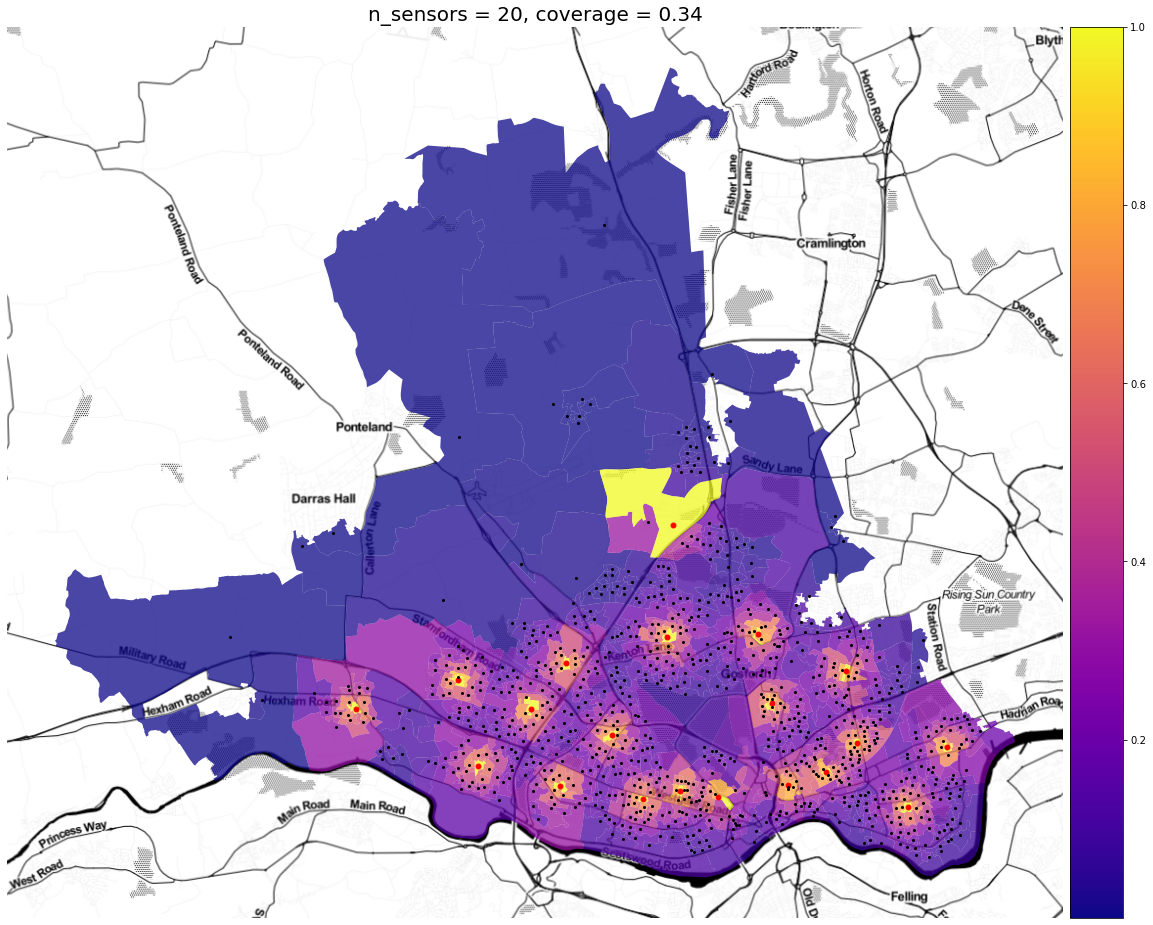

In [17]:
plot_sensors(sensors)

In [18]:
tyne_oa[sensors == 1]["oa11cd"].sort_values()

1      E00042043
36     E00042080
163    E00042214
202    E00042255
214    E00042267
252    E00042305
327    E00042381
375    E00042429
393    E00042447
466    E00042521
515    E00042570
564    E00042621
603    E00042661
604    E00042662
720    E00042791
744    E00042820
769    E00042846
800    E00042877
809    E00042886
937    E00175591
Name: oa11cd, dtype: object

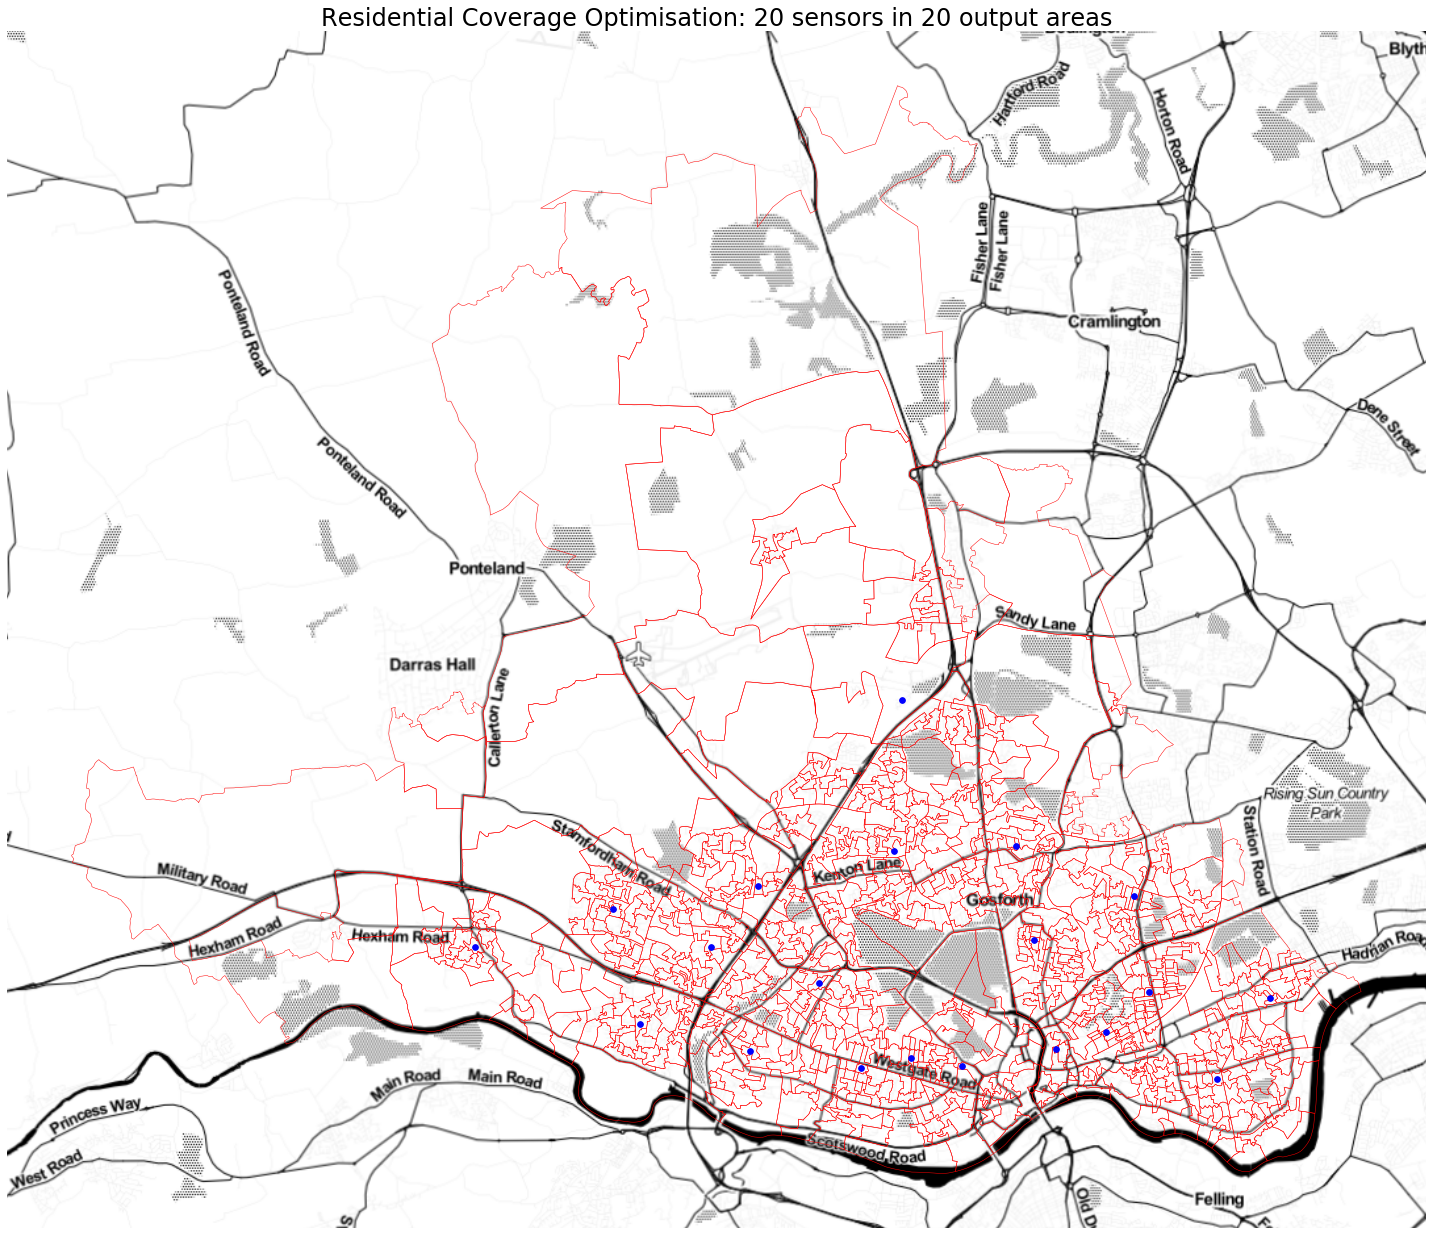

In [19]:
ax = tyne_oa.plot(figsize=(20,20), facecolor='none', edgecolor='red', linewidth=0.5)

ctx.add_basemap(ax,
                #url="https://maps.wikimedia.org/osm-intl/{z}/{x}/{y}.png",
                url="http://a.tile.stamen.com/toner/{z}/{x}/{y}.png",
                crs=tyne_oa.crs)

x = tyne_oa[sensors == 1]["X"]
y = tyne_oa[sensors == 1]["Y"]
ax.scatter(x, y, s=32, color='b')

plt.title("Residential Coverage Optimisation: {} sensors in {} output areas".format(n_sensors, n_sensors),
          fontsize=24)
ax.set_axis_off()

plt.tight_layout()
plt.savefig("../data/img/opt_sensors.png", dpi=300)

## PyGMO: vector of 0/1s for sensor at location or not

Fails to even meet constraints. But assume it has to "learn" how to make the vector sum up to n_sensors, which seems difficult.

In [20]:
# PyGMO User Defined Problem
class population_optimisation:
    def __init__(self, centroids, populations,
                 n_sensors=10, theta=500):
        
        self.n_sensors = n_sensors
        self.centroids = centroids
        self.populations = populations
        
        # dimension of problem = number of candidate sensor locations
        self.dim = len(populations)
        
        self.distances = self._calc_distances(centroids)

        self.distance_to_coverage = np.vectorize(self._scalar_coverage)        
        self.coverage = self.distance_to_coverage(distances, theta=theta)
     
    def fitness(self, sensors):
        """
        PyGMO required function.
        The objective function to minimise. And constraints to evaluate.
        """
        # only keep coverages due to output areas where a sensor is present
        mask_cov = np.multiply(coverage, sensors[np.newaxis, :])

        # coverage at each output area = coverage due to nearest sensor
        max_mask_cov = np.max(mask_cov, axis=1)
        
        # Total population-weighted coverage of solution = our objective
        fitness_sensors = -(self.populations * max_mask_cov).sum() / self.populations.sum()

        # constraint: have n_sensors sensors
        # equality constraints: must equal zero
        constraint_n_sensors = sensors.sum() - self.n_sensors
        
        return [fitness_sensors, constraint_n_sensors]
    

    def get_bounds(self):
        """
        PyGMO required function.
        Defines min and max value for each parameter.
        """
        return ([0]*self.dim, [1]*self.dim)
    
    def get_nec(self):
        """PyGMO function.
        Defines number of equality constraints."""
        return 1
    
    def get_nix(self):
        """
        PyGMO function.
        Number of integer dimensions.
        """
        return self.dim
    
    def gradient(self, x):
        return pg.estimate_gradient_h(lambda x: self.fitness(x), x)
    
    def _calc_distances(self, centroids):
        dist_sq = np.sum((centroids[:, np.newaxis, :] - centroids[np.newaxis, :, :]) ** 2,
                 axis = -1)

        distances = np.sqrt(dist_sq)
        
        return distances
    
    def _scalar_coverage(self, distance, theta):
        return np.exp(- distance/ theta)
    


In [21]:
# Build problem
prob = pg.problem(
        population_optimisation(centroids,
                                populations,
                                n_sensors,
                                theta)
      )

print(prob)

Problem name: <class '__main__.population_optimisation'>
	Global dimension:			952
	Integer dimension:			952
	Fitness dimension:			2
	Number of objectives:			1
	Equality constraints dimension:		1
	Inequality constraints dimension:	0
	Tolerances on constraints: [0]
	Lower bounds: [0, 0, 0, 0, 0, ... ]
	Upper bounds: [1, 1, 1, 1, 1, ... ]
	Has batch fitness evaluation: false

	Has gradient: true
	User implemented gradient sparsity: false
	Expected gradients: 1904
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0
	Gradient evaluations: 0

	Thread safety: none



In [22]:
# Create algorithm to solve problem with
algo = pg.algorithm(uda = pg.gaco())
algo.set_verbosity(1)
print(algo)

# population of problems
pop = pg.population(prob=prob, size=100)


Algorithm name: GACO: Ant Colony Optimization [stochastic]
	Thread safety: basic

Extra info:
	Generations: 100
	Accuracy parameter: 0.01
	Improvement stopping criterion: 100000
	Evaluation stopping criterion: 100000
	Focus parameter: 0
	Kernel: 63
	Oracle parameter: 0
	Pseudo-random number generator (Marsenne Twister 19937): 1094531814 2449398820 174534912 2867811587 1139872361 835578637 3261247783 2310547259 20183685 1077281666 2579856825 2941300178 3632849692 4184224328 440990373 3815780392 976684039 2030917076 436525595 929005498 3927830134 1134473534 120562929 2208828460 2635295806 2738474949 4168186013 2997036145 1275325563 107976255 4045864441 1814232513 1406786784 2723122662 2911764246 3759363847 3528358072 682538220 238267714 3605638449 2889815778 3628197513 472239772 3435134903 1971533360 3155925634 907179182 3464177365 3057178782 211612093 1333036227 760361661 4257229253 2677371219 886115883 1044159022 2611835486 774199941 3352355763 420676779 1454201523 2328627831 257187773

In [23]:
# solve problem
pop = algo.evolve(pop)

print("f evals", pop.problem.get_fevals())
print("g evals", pop.problem.get_gevals())
print("champion f", pop.champion_f)
print("n_sensors", pop.champion_x.sum())
print("min sensors at location", pop.champion_x.min())
print("max sensors at location", pop.champion_x.max())

f evals 10100
g evals 0
champion f [ -0.80675138 391.        ]
n_sensors 411.0
min sensors at location 0.0
max sensors at location 1.0


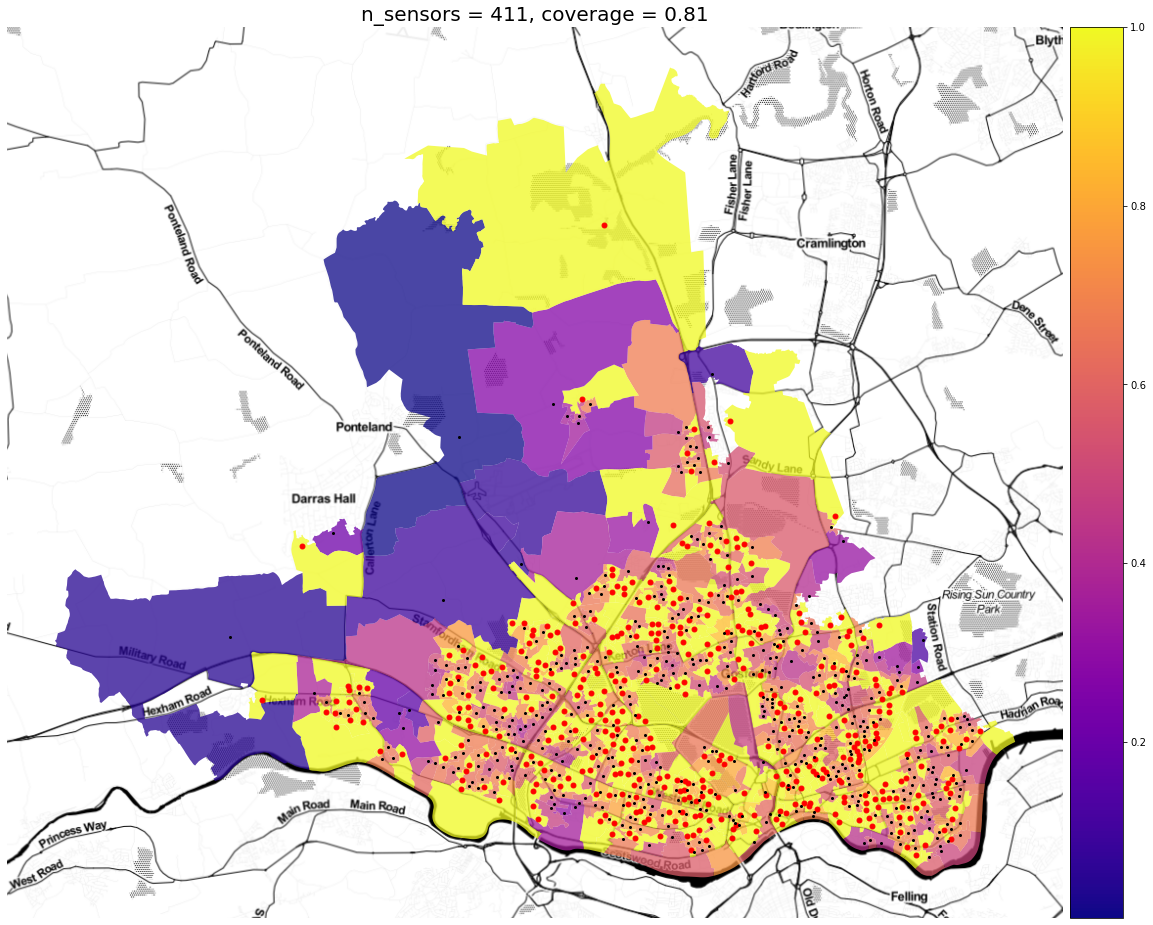

In [24]:
plot_sensors(pop.champion_x, print_sensors=False)

## PyGMO: Sensors at any arbitrary position (not only output area centroids)

In [25]:
# PyGMO User Defined Problem
class population_optimisation:
    def __init__(self, centroids, populations,
                 n_sensors=20, theta=500):
        
        self.n_sensors = n_sensors
        self.centroids = centroids
        self.populations = populations
        self.theta = theta
        
        self.distance_to_coverage = np.vectorize(self._scalar_coverage)        
     
    def fitness(self, sensors):
        """
        PyGMO required function.
        The objective function to minimise. And constraints to evaluate.
        """
        
        # convert 1D sensors vector into 2D array of X,Y coordinates
        sensors = sensors.reshape(self.n_sensors, 2)
        
        # calculate distance between sensors and output area centroids
        distances = self.calc_distances(sensors, centroids)

        # convert distances to coverage values
        # (coverage at each output area due to each sensor)
        coverage = self.distance_to_coverage(distances, theta=self.theta)
        

        # coverage at each output area = coverage due to nearest sensor
        max_cov = np.max(coverage, axis=0)
        
        # Total population-weighted coverage of solution = our objective
        fitness_sensors = -(self.populations * max_cov).sum() / self.populations.sum()

        return [fitness_sensors]
    
    def get_bounds(self):
        """
        PyGMO required function.
        Defines min and max value for each parameter.
        """
        min_xy = self.centroids.min(axis=0)
        max_xy = self.centroids.max(axis=0)
        
        return (list(min_xy)*self.n_sensors,
                list(max_xy)*self.n_sensors)
    
    def gradient(self, x):
        return pg.estimate_gradient_h(lambda x: self.fitness(x), x)
    
    def calc_distances(self, sensors, centroids):
        """distance between sensor locations and output area centroids"""
        dist_sq = np.sum((sensors[:, np.newaxis, :] - centroids[np.newaxis, :, :]) ** 2,
                         axis = -1)

        distances = np.sqrt(dist_sq)
        
        return distances
    
    def _scalar_coverage(self, distance, theta):
        return np.exp(- distance/ theta)
    


In [26]:
# Build problem
prob = pg.problem(
        population_optimisation(centroids,
                                populations,
                                n_sensors,
                                theta)
      )

print(prob)

Problem name: <class '__main__.population_optimisation'>
	Global dimension:			40
	Integer dimension:			0
	Fitness dimension:			1
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [413067, 563224, 413067, 563224, 413067, ... ]
	Upper bounds: [429850, 577386, 429850, 577386, 429850, ... ]
	Has batch fitness evaluation: false

	Has gradient: true
	User implemented gradient sparsity: false
	Expected gradients: 40
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0
	Gradient evaluations: 0

	Thread safety: none



In [27]:
# Create algorithm to solve problem with
algo = pg.algorithm(uda = pg.gaco())
algo.set_verbosity(1)
print(algo)

# population of problems
pop = pg.population(prob=prob, size=100)

Algorithm name: GACO: Ant Colony Optimization [stochastic]
	Thread safety: basic

Extra info:
	Generations: 100
	Accuracy parameter: 0.01
	Improvement stopping criterion: 100000
	Evaluation stopping criterion: 100000
	Focus parameter: 0
	Kernel: 63
	Oracle parameter: 0
	Pseudo-random number generator (Marsenne Twister 19937): 3858792885 1469551311 2550081864 3720995893 2437017426 3812965013 2563007284 3708619349 3238468086 107240114 3439266372 2567965966 1705284040 4101051738 377031979 637220102 1722163566 628660188 1222419934 1894434830 4263113983 658277249 3787909883 2483121135 382495129 3528952438 4208278851 3232262747 734203092 1872593857 4008098526 320011856 1690772912 160733174 1017944624 3320612115 217452404 663039209 1660053779 995890753 3137638605 2213865684 3323224728 621599314 254149766 4195712779 78538326 1106011677 531449148 1846373597 1687269118 18448846 2317972602 2163682189 2898048673 3869657478 462827185 873735438 1059658944 3034257403 1309914745 4155848085 1933929068 

In [28]:
# solve problem
pop = algo.evolve(pop)

print("f evals", pop.problem.get_fevals())
print("g evals", pop.problem.get_gevals())
print("champion f", pop.champion_f)
print("sensors", pop.champion_x)

f evals 10100
g evals 0
champion f [-0.25452006]
sensors [423888.83012053 569699.07704351 421152.80471461 577222.95220947
 416008.23146084 565963.1303948  419580.79978387 567174.5773557
 424119.01311686 564616.32356445 424542.55935763 567791.1610399
 428424.68029308 564958.89590511 426794.42691872 564580.83850002
 422065.72950156 568353.11952924 426101.32319219 564933.21946204
 420560.03736219 567502.15187243 425200.95883891 565597.61168551
 419155.99235563 571724.50649816 421056.00674491 566743.78616146
 425996.00070868 574839.52768797 428531.66826112 564067.22373023
 422513.92692426 564316.21639031 427312.93298557 565755.09857677
 424502.8954616  572890.4853625  418777.11668667 566064.14981068]


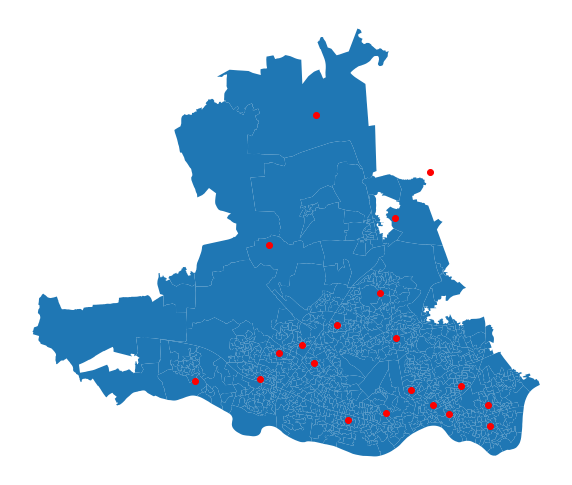

In [29]:
ax = tyne_oa.plot(figsize=(10,10))
ax.set_axis_off()

sensors = pop.champion_x
sensors = sensors.reshape(n_sensors, 2)
sensors_x = sensors[:, 0]
sensors_y = sensors[:, 1]
ax.scatter(sensors_x,sensors_y, color='r')

## scipy optimize

In [34]:
prob = population_optimisation(centroids,
                               populations,
                               n_sensors,
                               theta)

In [53]:
def objective(x):
    fitness = prob.fitness(x)
    return fitness[0]

In [59]:
x_range = [tyne_oa.X.min(), tyne_oa.X.max()]
print(x_range)
y_range = [tyne_oa.Y.min(), tyne_oa.Y.max()]
print(y_range)

x_mid = np.mean(x_range)
y_mid = np.mean(y_range)

init_sensors = [x_mid if x%2==0 else y_mid for x in range(2*n_sensors)]

sensor_bounds = [x_range if x%2==0 else y_range for x in range(2*n_sensors)]

[413067.0710000005, 429849.7170000002]
[563224.0130000003, 577386.1339999996]


In [36]:
# init sensors from results of previous pygmo optimisation
points = optimize.minimize(objective, sensors.reshape(2*n_sensors,))

points

[-0.25452005857486376]
[-0.25452005857486376]
[-0.2545200585748815]
[-0.25452005857489485]
[-0.25452005857487336]
[-0.2545200585748692]
[-0.2545200585748674]
[-0.25452005857495547]
[-0.25452005857484644]
[-0.25452005857481325]
[-0.25452005857461296]
[-0.254520058574729]
[-0.2545200585749163]
[-0.25452005857487986]
[-0.25452005857488563]
[-0.2545200585749062]
[-0.254520058575]
[-0.2545200585748168]
[-0.25452005857492593]
[-0.2545200585748608]
[-0.2545200585746571]
[-0.2545200585749207]
[-0.2545200585748446]
[-0.2545200585749275]
[-0.254520058574967]
[-0.2545200585750036]
[-0.2545200585748637]
[-0.2545200585748663]
[-0.2545200585749308]
[-0.25452005857473897]
[-0.25452005857486376]
[-0.25452005857486376]
[-0.2545200585748588]
[-0.2545200585748401]
[-0.25452005857470245]
[-0.25452005857498844]
[-0.25452005857474164]
[-0.2545200585749814]
[-0.25452005857479504]
[-0.25452005857485355]
[-0.2545200585748688]
[-0.2545200585748286]
[-0.25452005993187926]
[-0.25452005993187926]
[-0.2545200599318

[-0.25454970085872947]
[-0.2545497008587245]
[-0.2545497008587058]
[-0.2545497008585682]
[-0.2545497008588541]
[-0.25454970085860745]
[-0.2545497008588471]
[-0.25454970085866085]
[-0.2545497008587193]
[-0.2545497008587345]
[-0.2545497008586944]
[-0.2546386079484039]
[-0.2546386079484039]
[-0.25463860794842164]
[-0.254638607948435]
[-0.2546386079484135]
[-0.25463860794840926]
[-0.2546386079484075]
[-0.25463860794849563]
[-0.2546386079483866]
[-0.2546386079483534]
[-0.2546386079481518]
[-0.2546386079482693]
[-0.2546386079484564]
[-0.25463860794841997]
[-0.25463860794842563]
[-0.2546386079484462]
[-0.2546386079485396]
[-0.2546386079483564]
[-0.254638607948466]
[-0.25463860794840093]
[-0.2546386079481976]
[-0.25463860794846]
[-0.2546386079483848]
[-0.2546386079484675]
[-0.254638607948507]
[-0.25463860794854376]
[-0.2546386079484038]
[-0.2546386079484064]
[-0.25463860794847054]
[-0.2546386079482793]
[-0.2546386079484039]
[-0.2546386079484039]
[-0.25463860794839893]
[-0.2546386079483802]
[-0

[-0.2730237488430095]
[-0.27302374884302927]
[-0.2730237488430712]
[-0.2730237488432172]
[-0.2730237488430222]
[-0.2730237488430249]
[-0.27302374884309205]
[-0.2730237488429638]
[-0.27302374884302233]
[-0.27302374884302233]
[-0.2730237488430225]
[-0.2730237488430033]
[-0.27302374884302827]
[-0.27302374884291114]
[-0.27302374884314434]
[-0.2730237488429845]
[-0.27302374884295383]
[-0.2730237488430268]
[-0.2730237488430473]
[-0.2730237488430173]
[-0.2730258194954149]
[-0.2730258194954149]
[-0.27302581949542476]
[-0.27302581949545873]
[-0.273025819495425]
[-0.27302581949542054]
[-0.2730258194953989]
[-0.27302581949552707]
[-0.2730258194954185]
[-0.27302581949536375]
[-0.27302581949549]
[-0.27302581949557403]
[-0.27302581949547977]
[-0.2730258194954448]
[-0.2730258194954594]
[-0.27302581949542676]
[-0.27302581949544635]
[-0.27302581949543625]
[-0.2730258194954707]
[-0.27302581949542365]
[-0.2730258194953688]
[-0.2730258194951674]
[-0.27302581949540217]
[-0.27302581949542193]
[-0.2730258194

[-0.2730271700992656]
[-0.27302717009923316]
[-0.2730271700992542]
[-0.2730271700992411]
[-0.2730271700992774]
[-0.27302717009923005]
[-0.27302717009917327]
[-0.2730271700989764]
[-0.2730271700992085]
[-0.27302717009922833]
[-0.27302717009926997]
[-0.2730271700994157]
[-0.27302717009922106]
[-0.2730271700992237]
[-0.273027170099291]
[-0.2730271700991616]
[-0.2730271700992212]
[-0.2730271700992212]
[-0.27302717009922134]
[-0.273027170099202]
[-0.27302717009922034]
[-0.2730271700991057]
[-0.273027170099341]
[-0.2730271700991833]
[-0.27302717009915245]
[-0.27302717009922545]
[-0.27302717009924604]
[-0.2730271700992162]
[-0.2730272244216076]
[-0.2730272244216076]
[-0.27302722442161753]
[-0.2730272244216514]
[-0.27302722442161764]
[-0.27302722442161326]
[-0.27302722442159166]
[-0.27302722442171967]
[-0.27302722442161087]
[-0.27302722442155625]
[-0.2730272244216823]
[-0.27302722442176575]
[-0.27302722442167243]
[-0.27302722442163746]
[-0.27302722442165195]
[-0.27302722442161953]
[-0.27302722

[-0.273045526400879]
[-0.2730455264008572]
[-0.27304552640098567]
[-0.27304552640087815]
[-0.27304552640082286]
[-0.27304552640094537]
[-0.27304552640103114]
[-0.2730455264009381]
[-0.273045526400903]
[-0.2730455264009181]
[-0.273045526400885]
[-0.2730455264008996]
[-0.27304552640089885]
[-0.2730455264009279]
[-0.2730455264008818]
[-0.2730455264008325]
[-0.2730455264006172]
[-0.2730455264008603]
[-0.27304552640087987]
[-0.2730455264009222]
[-0.2730455264010685]
[-0.2730455264008732]
[-0.27304552640087587]
[-0.27304552640094343]
[-0.27304552640081803]
[-0.2730455264008733]
[-0.2730455264008733]
[-0.2730455264008735]
[-0.2730455264008544]
[-0.27304552640088686]
[-0.2730455264007634]
[-0.27304552640099766]
[-0.27304552640083546]
[-0.2730455264008052]
[-0.2730455264008781]
[-0.2730455264008984]
[-0.2730455264008682]
[-0.27305023369966747]
[-0.27305023369966747]
[-0.27305023369967685]
[-0.27305023369971165]
[-0.2730502336996776]
[-0.2730502336996732]
[-0.2730502336996513]
[-0.27305023369978

[-0.27369856130933273]
[-0.27369856130947773]
[-0.2736985613093563]
[-0.2736985613093137]
[-0.27369856130938686]
[-0.2736985613094071]
[-0.2736985613093786]
[-0.27406431420924116]
[-0.27406431420924116]
[-0.2740643142092518]
[-0.2740643142092849]
[-0.2740643142092512]
[-0.2740643142092468]
[-0.2740643142092264]
[-0.27406431420935273]
[-0.27406431420923966]
[-0.274064314209189]
[-0.2740643142092895]
[-0.27406431420937416]
[-0.2740643142093057]
[-0.2740643142092705]
[-0.2740643142092771]
[-0.27406431420925376]
[-0.2740643142092749]
[-0.27406431420925265]
[-0.27406431420930066]
[-0.27406431420925137]
[-0.2740643142091777]
[-0.27406431420903066]
[-0.2740643142092318]
[-0.2740643142092507]
[-0.2740643142092836]
[-0.2740643142094176]
[-0.2740643142092411]
[-0.2740643142092437]
[-0.274064314209311]
[-0.27406431420917343]
[-0.27406431420924116]
[-0.27406431420924116]
[-0.2740643142092359]
[-0.2740643142092224]
[-0.2740643142091732]
[-0.2740643142092071]
[-0.2740643142093235]
[-0.27406431420922

[-0.2854619835946777]
[-0.2854619835947103]
[-0.2854619835947103]
[-0.28546198359470343]
[-0.2854619835947024]
[-0.2854619835947272]
[-0.2854619835947116]
[-0.2854619835947375]
[-0.28546198359471403]
[-0.28546198359466873]
[-0.2854619835947168]
[-0.2854619835947247]
[-0.285461983594698]
[-0.2854641201218767]
[-0.2854641201218767]
[-0.285464120121883]
[-0.28546412012192873]
[-0.2854641201218872]
[-0.2854641201218826]
[-0.2854641201218538]
[-0.2854641201219455]
[-0.28546412012189865]
[-0.28546412012190575]
[-0.28546412012192524]
[-0.2854641201219012]
[-0.285464120121919]
[-0.28546412012191325]
[-0.28546412012192457]
[-0.2854641201219025]
[-0.28546412012183386]
[-0.2854641201218797]
[-0.28546412012192507]
[-0.28546412012186034]
[-0.28546412012196404]
[-0.28546412012206734]
[-0.28546412012187017]
[-0.285464120121879]
[-0.28546412012189076]
[-0.2854641201219532]
[-0.28546412012187666]
[-0.2854641201218793]
[-0.2854641201219447]
[-0.2854641201218417]
[-0.2854641201218767]
[-0.285464120121876

[-0.28547022954014295]
[-0.2854702295402653]
[-0.28547022954035195]
[-0.2854702295401535]
[-0.28547022954016227]
[-0.28547022954017187]
[-0.2854702295402316]
[-0.28547022954016]
[-0.28547022954016266]
[-0.28547022954022655]
[-0.28547022954012624]
[-0.2854702295401601]
[-0.2854702295401601]
[-0.28547022954015316]
[-0.28547022954015194]
[-0.2854702295401762]
[-0.28547022954015944]
[-0.2854702295401902]
[-0.2854702295401637]
[-0.2854702295401173]
[-0.28547022954016726]
[-0.2854702295401744]
[-0.28547022954014795]
[-0.28547027728609997]
[-0.28547027728609997]
[-0.285470277286106]
[-0.28547027728615204]
[-0.28547027728611046]
[-0.2854702772861059]
[-0.2854702772860766]
[-0.2854702772861681]
[-0.2854702772861223]
[-0.2854702772861295]
[-0.28547027728614854]
[-0.28547027728612234]
[-0.2854702772861414]
[-0.2854702772861366]
[-0.2854702772861478]
[-0.28547027728612584]
[-0.2854702772860557]
[-0.28547027728610425]
[-0.28547027728614877]
[-0.2854702772860829]
[-0.2854702772862056]
[-0.2854702772

[-0.28547997002388925]
[-0.28547997002385633]
[-0.2854799700238813]
[-0.2854799700238779]
[-0.2854799700238888]
[-0.28547997002386716]
[-0.2854799700237957]
[-0.28547997002384556]
[-0.2854799700238905]
[-0.2854799700238228]
[-0.28547997002395686]
[-0.28547997002402997]
[-0.28547997002383463]
[-0.2854799700238433]
[-0.28547997002385317]
[-0.28547997002390224]
[-0.28547997002384107]
[-0.28547997002384373]
[-0.2854799700239057]
[-0.2854799700238087]
[-0.2854799700238412]
[-0.2854799700238412]
[-0.28547997002383424]
[-0.2854799700238333]
[-0.2854799700238556]
[-0.28547997002384606]
[-0.28547997002386694]
[-0.2854799700238444]
[-0.2854799700237999]
[-0.28547997002384756]
[-0.2854799700238555]
[-0.2854799700238288]
[-0.28548710505935154]
[-0.28548710505935154]
[-0.28548710505935776]
[-0.28548710505940583]
[-0.28548710505936203]
[-0.2854871050593574]
[-0.28548710505932756]
[-0.2854871050594181]
[-0.2854871050593741]
[-0.2854871050593818]
[-0.28548710505939934]
[-0.2854871050593645]
[-0.285487

[-0.28711591377786566]
[-0.28711591377786566]
[-0.28711591377786794]
[-0.2871159137779207]
[-0.2871159137778764]
[-0.28711591377787166]
[-0.28711591377784085]
[-0.28711591377791085]
[-0.287115913777887]
[-0.28711591377789464]
[-0.2871159137779146]
[-0.28711591377786067]
[-0.28711591377789664]
[-0.2871159137779011]
[-0.2871159137779243]
[-0.2871159137778921]
[-0.2871159137778244]
[-0.2871159137778753]
[-0.2871159137779335]
[-0.2871159137778363]
[-0.28711591377803103]
[-0.2871159137780507]
[-0.28711591377786255]
[-0.28711591377787155]
[-0.2871159137778503]
[-0.28711591377780593]
[-0.28711591377786555]
[-0.2871159137778682]
[-0.287115913777932]
[-0.28711591377783485]
[-0.28711591377786566]
[-0.28711591377786566]
[-0.2871159137778538]
[-0.28711591377785395]
[-0.28711591377797785]
[-0.2871159137778785]
[-0.28711591377787016]
[-0.28711591377786183]
[-0.2871159137778359]
[-0.2871159137778602]
[-0.28711591377788104]
[-0.2871159137778517]
[-0.2885328503264578]
[-0.2885328503264578]
[-0.28853285

In [58]:
# init sensors to mid-points
points = optimize.minimize(objective, init_sensors)

points

      fun: -0.004671948229816732
 hess_inv: array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])
      jac: array([-4.27942723e-06, -6.36791810e-07, -4.27942723e-06, -6.36791810e-07,
       -4.27942723e-06, -6.36791810e-07, -4.27942723e-06, -6.36791810e-07,
       -4.27942723e-06, -6.36791810e-07, -4.27942723e-06, -6.36791810e-07,
       -4.27942723e-06, -6.36791810e-07, -4.27942723e-06, -6.36791810e-07,
       -4.27942723e-06, -6.36791810e-07, -4.27942723e-06, -6.36791810e-07,
       -4.27942723e-06, -6.36791810e-07, -4.27942723e-06, -6.36791810e-07,
       -4.27942723e-06, -6.36791810e-07, -4.27942723e-06, -6.36791810e-07,
       -4.27942723e-06, -6.36791810e-07, -4.27942723e-06, -6.36791810e-07,
       -4.27942723e-06, -6.36791810e-07, -4.27942723e-06, -6.36791810e-07,
       -4.27942723e-06, -6.36791810e-07, -4.27942723e-06, -6.3679

In [61]:
# SLOW!!!
points = optimize.differential_evolution(objective, sensor_bounds)

points

/Users/jroberts/opt/anaconda3/envs/spatial-inequality/lib/python3.7/site-packages/scipy/optimize/_differentialevolution.py:494: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  " updating='deferred'", UserWarning)
Process ForkPoolWorker-12:
Process ForkPoolWorker-3:
Process ForkPoolWorker-9:
Process ForkPoolWorker-8:
Process ForkPoolWorker-2:
Process ForkPoolWorker-6:
Process ForkPoolWorker-4:
Process ForkPoolWorker-1:
Process ForkPoolWorker-10:
Process ForkPoolWorker-5:
Process ForkPoolWorker-7:
Process ForkPoolWorker-11:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/jroberts/opt/anaconda3/envs/spatial

KeyboardInterrupt: 